In [106]:
import numpy as np
import matplotlib.pyplot as plt
import trimesh
from trimesh.viewer import SceneViewer
import pyrender
import pyglet
import h5py
import PIL
from data_def import PCAModel, Mesh
from ipywidgets import *

import torch
from torch.autograd import Variable


In [62]:
# Load data
fland = np.loadtxt("Landmarks68_model2017-1_face12_nomouth.anl", dtype=int)
bfm = h5py.File("Data/model2017-1_face12_nomouth.h5", 'r')

#bfm.visititems(print_attrs)
mean_shape = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
sigma2_shape = np.asarray(bfm['shape/model/pcaVariance'])[:30]
basis_shape = np.asarray(bfm['shape/model/pcaBasis']).reshape((-1, 3, 199))[:, :, :30]

print(mean_shape.shape, sigma2_shape.shape, basis_shape.shape)

mean_expression = np.asarray(bfm['expression/model/mean']).reshape((-1, 3))
sigma2_expression = np.asarray(bfm['expression/model/pcaVariance'])[:20]
basis_expression = np.asarray(bfm['expression/model/pcaBasis']).reshape((-1, 3, 100))[:, :, :20]

print(mean_expression.shape, sigma2_expression.shape, basis_expression.shape)

mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T

print(mean_tex.shape, triangles.shape)

(28588, 3) (30,) (28588, 3, 30)
(28588, 3) (20,) (28588, 3, 20)
(28588, 3) (56572, 3)


In [84]:
# np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
# np.asarray(bfm['shape/model'])
x = basis_expression @ (0.2 * np.sqrt(sigma2_expression))
x.shape

(28588, 3)

In [8]:
# Utils

def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("\t%s: %s" % (key, val))

def render_mesh(mesh):
    mesh = pyrender.Mesh.from_trimesh(mesh)
    scene = pyrender.Scene()
    scene.add(mesh)
    #pyrender.Viewer(scene, use_raymond_lighting=True)

    # Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    camera_pose = np.eye(4)
    camera_pose[2, 3] = 250
    scene.add(camera, pose=camera_pose)

    # Set up the light -- a single spot light in the same spot as the camera
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=5.0)
    #light = pyrender.PointLight(color=np.ones(3), intensity=0.01)
    scene.add(light, pose=camera_pose)

    # Render the scene
    r = pyrender.OffscreenRenderer(512, 512)
    color, depth = r.render(scene)
    return color, depth


def get_mesh(shape):
    mesh = trimesh.base.Trimesh(vertices=shape, faces=triangles, vertex_colors=mean_tex)
    return mesh

# Example of an average shape

In [58]:
mesh = Mesh(mean_shape, mean_tex, triangles)
mesh = trimesh.base.Trimesh(vertices=mesh.vertices, faces=mesh.triangles, vertex_colors=mesh.colors)
mesh.show()

# Morphable Model

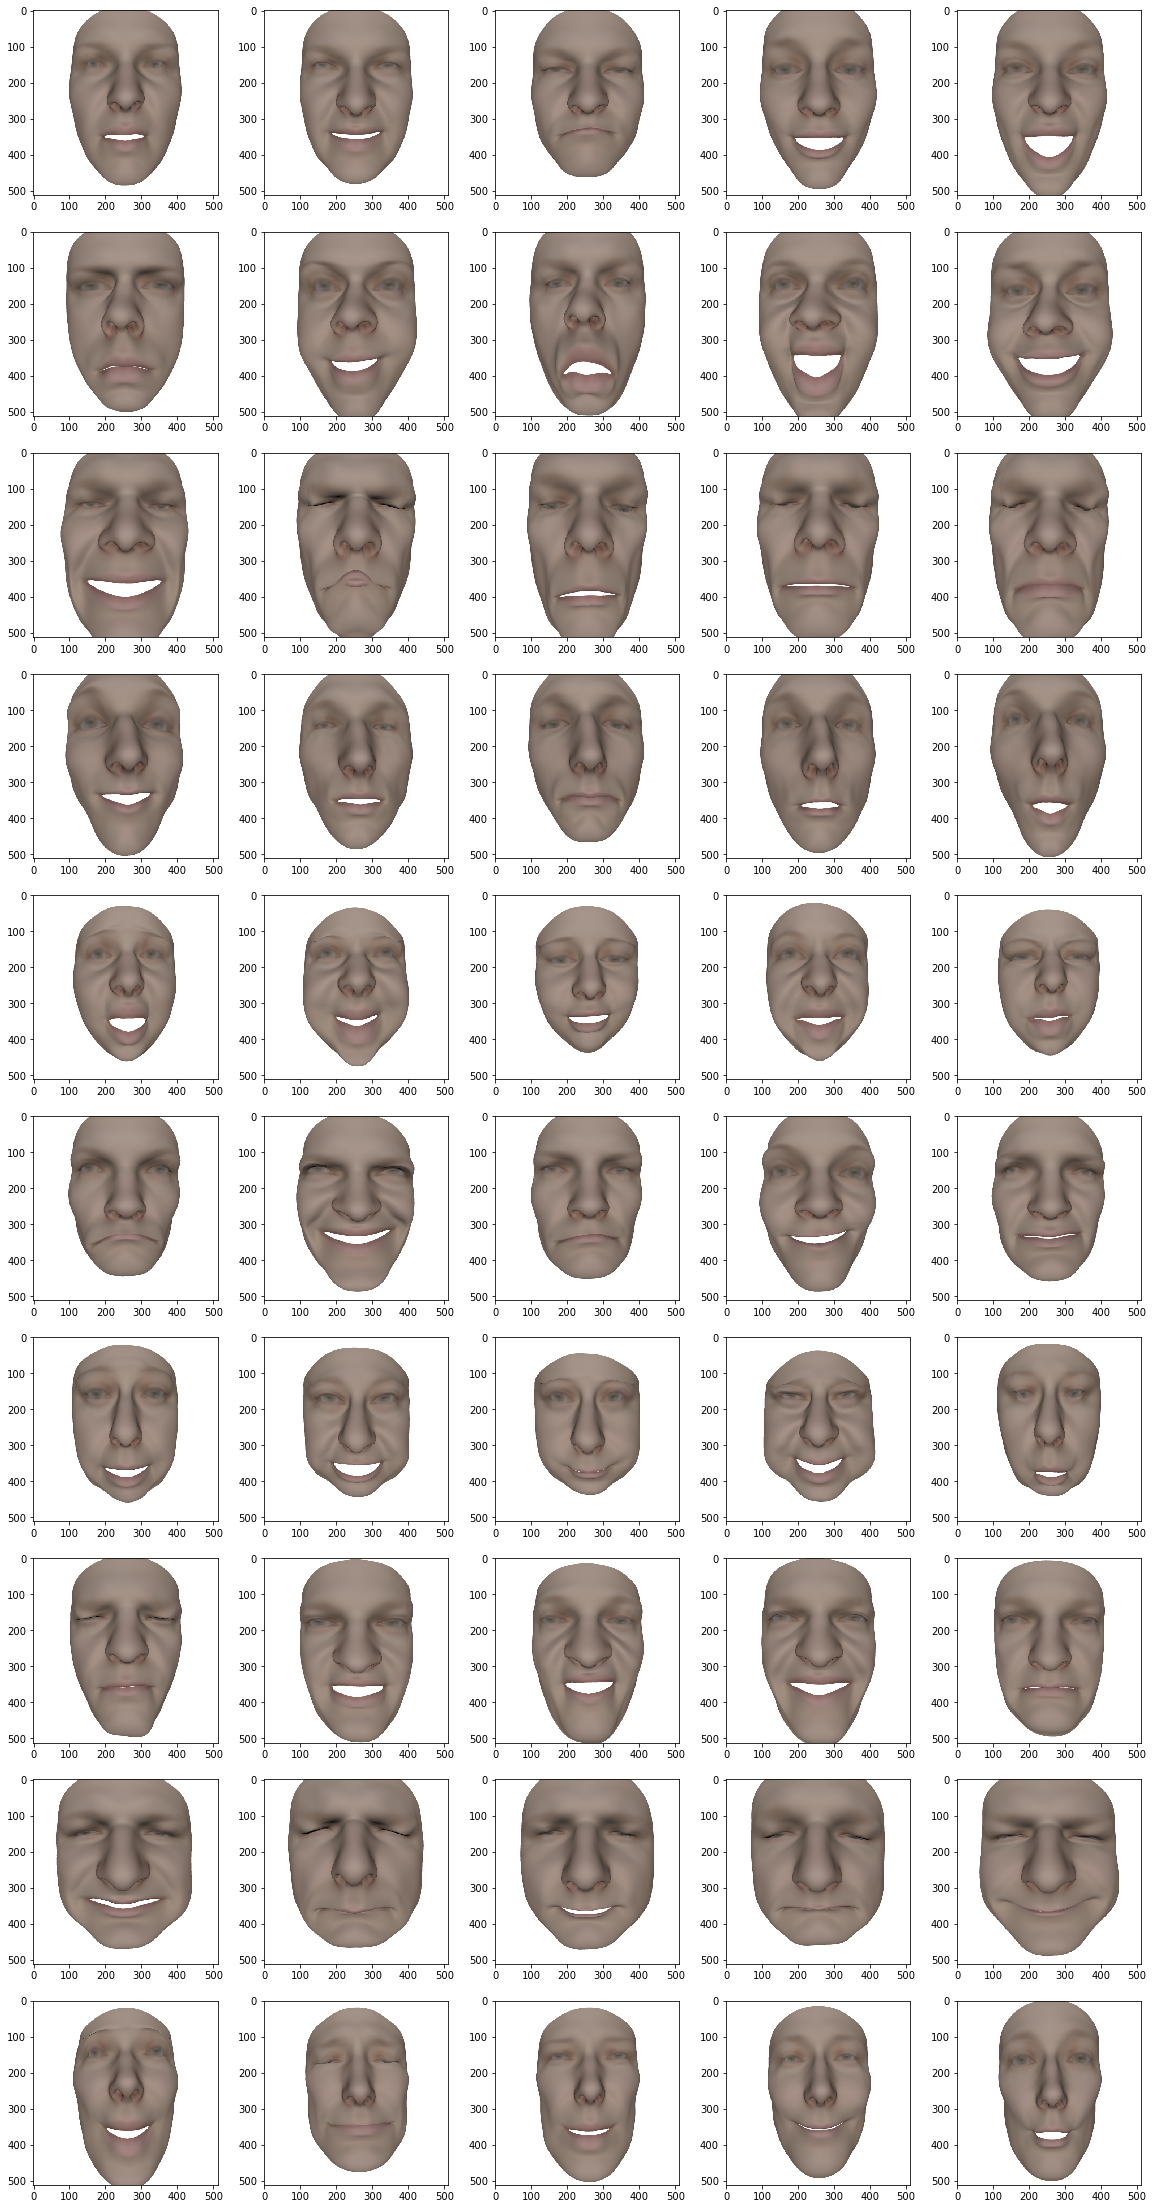

In [136]:
new_face = lambda alpha, beta: mean_shape + mean_expression \
           + basis_shape @ (alpha * np.sqrt(sigma2_shape)) \
           + basis_expression @ (beta * np.sqrt(sigma2_expression))

NCOLS=5
NROWS=10

%matplotlib inline
plt.figure(figsize=(20, 40))
alpha = 0
for i in range(NCOLS * NROWS):
    plt.subplot(NROWS, NCOLS, i + 1)
    if i > 0 and i % NCOLS == 0:
        alpha = np.random.uniform(-3, 3, 30)
    beta = np.random.uniform(-3, 3, 20)
    mesh = trimesh.base.Trimesh(
        vertices=new_face(alpha, beta), 
        faces=triangles, 
        vertex_colors=mean_tex
    )
    color, depth = render_mesh(mesh)
    plt.imshow(color)

plt.savefig("sampled_faces.png")
plt.show()


# Pinhole camera model

## Question 1)

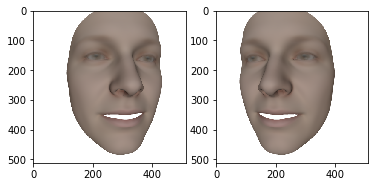

In [134]:
def get_rot_mat_y(angle):  
    angle = angle * np.pi / 180 
    m = np.eye(4)
    m[:3, :3] = np.array((
         (np.cos(angle), 0, np.sin(angle)),
         (0, 1, 0),
         (-np.sin(angle), 0, np.cos(angle))
    ))
    return m

mesh = trimesh.base.Trimesh(
    vertices=new_face(0, 0), 
    faces=triangles, 
    vertex_colors=mean_tex
)

points = mesh.vertices.T
ncoords, npoints = points.shape
S = np.vstack((points, np.ones(npoints)))



plt.subplot(1, 2, 1)
mesh.vertices = (get_rot_mat_y(10) @ S)[:3].T
color, depth = render_mesh(mesh)
plt.imshow(color)

plt.subplot(1, 2, 2)
mesh.vertices = (get_rot_mat_y(-10) @ S)[:3].T
color, depth = render_mesh(mesh)
plt.imshow(color)
plt.show()

## Question 2

In [108]:
from collections import namedtuple


class ViewportMatrix(np.ndarray):
    """Assumes the order of the coordinates to be X, Y, Z
    Where Y is the height and Z the depth.
    """

    def __new__(cls, l=-1, r=1, t=1, b=-1):
        m = np.zeros((4, 4))
        m += np.diag(((r - l) / 2, (t - b) / 2, 0.5, 1))
        m[3, :3] = ((r + l) / 2, (t + b) / 2, 0.5)
        return m.view(cls)


class PerspectiveMatrix(np.ndarray):
    """Assumes the order of the coordinates to be X, Y, Z"""
    FOV_SETTINGS = namedtuple(
        'FovSettings', 
        'top bottom left right near far'
    )
    DEFAULT_FOV = FOV_SETTINGS(1, -1, 1, -1, 9.9, 10)
    
    def __new__(cls, *args, **kwargs):
        return np.zeros((4, 4)).view(cls)

    def __init__(self, fov=(1, -1, 1, -1, 9.9, 10)):
        fov = self.FOV_SETTINGS(*fov)

        # Build the perspective proj matrix
        self[0, 0] = 2 * fov.near / (fov.right - fov.left)
        self[0, 2] = (fov.right + fov.left) / (fov.right - fov.left)
        
        self[1, 1] = 2 * fov.near / (fov.top - fov.bottom)
        self[1, 2] = (fov.top + fov.bottom) / (fov.top - fov.bottom)
        
        self[2, 2] = - (fov.far + fov.near) / (fov.far - fov.near)
        self[2, 3] = - 2 * fov.far * fov.near / (fov.far - fov.near)
        self[3, 2] = -1


class TransformationMatrix(np.ndarray):
    """Assumes the order of the coordinates to be X, Y, Z"""
    def __new__(cls):
        return np.eye(4).view(cls)

    def reset(self):
        self[:] = np.eye(4)

    def translate(self, point):
        self[0:3, 3] += np.array(point)
    
    def rotate_y(self, angle):
        angle = angle * np.pi / 180 
        rot = np.array((
            (np.cos(angle), 0, np.sin(angle)),
            (0, 1, 0),
            (-np.sin(angle), 0, np.cos(angle))
        ))
        self[0:3, 0:3] = self[:3, :3] @ rot

        
def projection(S, d=-500, n=0.1, yrot=10):
    T = TransformationMatrix()
    T.rotate_y(yrot)
    T.translate((0, 0, d))
    P = PerspectiveMatrix((1, -1, 1, -1, n, 100))
    V = ViewportMatrix()
    p = P @ T @ S
    # Convert homogeneous
    p = p / p[3, :]
    p = V @ p
    p = p[:2, :]
    return p


(4, 4)


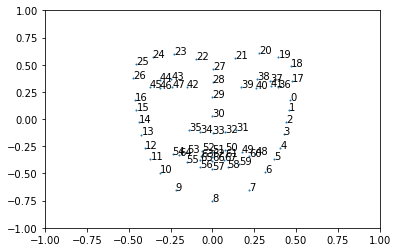

In [135]:
points = mean_shape[fland].T
ncoords, npoints = points.shape
# mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))

S = np.vstack((points, np.ones(npoints)))

p = projection(S, d=-200, n=1, yrot=0)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
c = ax.scatter(*p, s=1)

# Annotate
for i in np.arange(len(fland)):
    ax.annotate(str(i), (p[0][i], p[1][i]))

plt.ylim((-1, 1))
plt.xlim((-1, 1))
#plt.axis('equal')
plt.show()

# Latent parameters estimation

## Dlib's face landmark detection
Code from http://dlib.net/face_landmark_detection.py.html (Some parts slightly adjusted for our purposes)

In [120]:
import sys
import os
import dlib
import glob

predictor_path = "Data/shape_predictor_68_face_landmarks.dat"
f = "faces/dan.jpg"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
win = dlib.image_window()
img = dlib.load_rgb_image(f)

win.clear_overlay()
win.set_image(img)

# Ask the detector to find the bounding boxes of each face. The 1 in the
# second argument indicates that we should upsample the image 1 time. This
# will make everything bigger and allow us to detect more faces.
dets = detector(img, 1)
print("Number of faces detected: {}".format(len(dets)))
for k, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        k, d.left(), d.top(), d.right(), d.bottom()))
    # Get the landmarks/parts for the face in box d.
    gt_shape = predictor(img, d)
    print("Part 0: {}, Part 1: {} ...".format(shape.part(0),
                                              shape.part(1)))
    # Draw the face landmarks on the screen.
    win.add_overlay(shape)

Number of faces detected: 1
Detection 0: Left: 56 Top: 98 Right: 242 Bottom: 284
Part 0: (64, 172), Part 1: (66, 193) ...


## Optimization

In [143]:
mean_shape_opt = torch.Tensor(mean_shape[fland])
basis_shape_opt = torch.Tensor(basis_shape[fland])
mean_expression_opt = torch.Tensor(mean_expression[fland])
basis_expression_opt = torch.Tensor(basis_expression[fland])

new_face_opt = lambda alpha, delta: mean_shape_opt + mean_expression_opt \
           + basis_shape_opt @ (alpha * np.sqrt(sigma2_shape)) \
           + basis_expression_opt @ (delta * np.sqrt(sigma2_expression))

lamb_aplha = 0.5
lamb_delta = 0.5
lr = 0.1

gt_landmarks = torch.Tensor(np.asarray([[shape.part(i).x, shape.part(i).y] for i in np.arange(68)]))
n_points, dim_points = gt_landmarks.shape
P = torch.Tensor(PerspectiveMatrix((1, -1, 1, -1, n, 100)))
V = torch.Tensor(ViewportMatrix())

T = Variable(torch.randn(4, 4), requires_grad=True)
alpha = Variable(torch.randn(n_points, 1), requires_grad=True)
delta = Variable(torch.randn(n_points, 1), requires_grad=True)

opt = torch.optim.Adam([T], lr=lr)
for i in range(100):
    opt.zero_grad()
    
    G_ad = new_face_opt(alpha, delta)
    print(G_ad.shape)
    
    p = P @ T @ S
    # Convert homogeneous
    p = p / p[3, :]
    p = V @ p
    p = torch.t(p[:2, :])

    loss = (p - gt_landmarks).pow(2).sum() + \
            (lamb_aplha*alpha.pow(2).sum() + \
             lamb_delta*delta.pow(2).sum())
    loss.backward()
    print(loss.item())
    opt.step()


TypeError: mul(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

(3, 68)
torch.Size([68, 2])
tensor(6988942.5000)


In [111]:
# T = torch.normal(0, 0.2, out=(4,4))

TypeError: normal() received an invalid combination of arguments - got (int, float, tuple), but expected one of:
 * (Tensor mean, Tensor std, torch.Generator generator, Tensor out)
 * (Tensor mean, float std, torch.Generator generator, Tensor out)
 * (float mean, Tensor std, torch.Generator generator, Tensor out)
